<a href="https://colab.research.google.com/github/quimHM/QHM_TFG_repository/blob/main/draft_ML_finalproject_QUIMHM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PREDICTING UCI credit card approvals (and studying the BIAS in our data and model)**

[Quim De Las Heras Molins (21123349)

FINAL PROJECT CS401 -
December 2021]

Source of the dataset: 
https://archive.ics.uci.edu/ml/datasets/credit+approval

In [ ]:
#IMPORTS AND NEEDED LIBRARIES
import pandas as pd
import numpy as np

#DATA PREPARATION
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#MODEL TRAINING AND TESTING
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

#BIAS ANALISIS
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt

#UNUSED IMPORTS FROM A2
#import matplotlib.pyplot as plt
#from sklearn.metrics import roc_curve,roc_auc_score

#import tensorflow as tf
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

**DRIVE** MOUNTING (IN ORDER TO SOURCE THE INPUT DATASET FROM THE CLOUD)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**IMPORTING** OF THE DATASET (EDITABLE TO CHANGE INPUT SOURCE ACCORDINGLY)

In [ ]:
# Load dataset
dataset = pd.read_csv('/content/drive/MyDrive/ML (maynooth)/FINAL PROJECT/credit.data', header=None)#TODO: COMMENT TO RUN LOCALY
#dataset = pd.read_csv('/credit.data', header=None) #TODO: UNCOMMENT FOR LOCAL EXECUTION, IF INPUT IN THE SAME DIRECTORY

# Inspect data and check correct reading 
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


# DATA **INSPECTION**

The dataset consists of 690 instances of 16 features (specifically we have float64, int64 and object data types).


Some are numerical, spread across different apparent range widths, and some categorical, and have been transformed into meanngless symbols to protect the confidentiality of the data. However, this [blog by Ryan Khuhn](http://rstudio-pubs-static.s3.amazonaws.com/73039_9946de135c0a49daa7a0a9eda4a67a72.html#interpret-the-model-and-research-questions-answered) does offer us some insight on the probable labels that are been encoded:
Gender, Age, Debt, Married, BankCustomer, EducationLevel, Ethnicity, YearsEmployed, PriorDefault, Employed, CreditScore, DriversLicense, Citizen, ZipCode, Income and finally the ApprovalStatus


On first glance it could seem that no null or empty records exist in the dataframe but a closer inspection to some of the unique values of the non-numerical fetures quickly revealed that missing entries are filled with '?' symbols across the whole structure.

In [ ]:
# Print Dataframe information summary (100000 samples, no nulls, 10 features and 1 binary output label, different ranges for each feature)
print(dataset.describe())
print(dataset.info())
somenonnumerical = [0,3,4,5,6]
for i in somenonnumerical: print(i,pd.unique(dataset[i]))

               2           7          10             14
count  690.000000  690.000000  690.00000     690.000000
mean     4.758725    2.223406    2.40000    1017.385507
std      4.978163    3.346513    4.86294    5210.102598
min      0.000000    0.000000    0.00000       0.000000
25%      1.000000    0.165000    0.00000       0.000000
50%      2.750000    1.000000    0.00000       5.000000
75%      7.207500    2.625000    3.00000     395.500000
max     28.000000   28.500000   67.00000  100000.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-

# DATA **PREPARATION**

First of all...........[TO BE PROPERLY DEVELOPED]
Deal with categorical features, empty entries, and unequal ranges.

Also, train and test sets

In [ ]:
#original length and "aparent" null values
print(len(dataset.values))
print(dataset.isnull().values.sum())

#unchanged length and real amount of null values
dataset = dataset.replace('?', np.nan)
print(len(dataset.values))
print(dataset.isnull().values.sum())

#entries containing null values are currently droped 
#(other ways to deal with null values:https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779)
dataset=dataset.dropna()
print(len(dataset.values))
print(dataset.isnull().values.sum())

690
0
690
67
653
0


In [ ]:
#features containing categorical values are currently encoded using OrdinalEncoder()
#(other ways to deal with categorical features:https://pbpython.com/categorical-encoding.html)

#target feature is "encoded" manually to ensure '+'=1, '-'=0
dataset[15].replace('+', 1.0, inplace=True)
dataset[15].replace('-', 0.0, inplace=True)

oe = OrdinalEncoder() 

for col in dataset.columns:
    if dataset[col].dtype=='object':
        dataset[col] = oe.fit_transform(dataset[[col]])
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.0,153.0,0.000,1.0,0.0,12.0,7.0,1.25,1.0,1.0,1,0.0,0.0,68.0,0,1.0
1,0.0,321.0,4.460,1.0,0.0,10.0,3.0,3.04,1.0,1.0,6,0.0,0.0,11.0,560,1.0
2,0.0,88.0,0.500,1.0,0.0,10.0,3.0,1.50,1.0,0.0,0,0.0,0.0,94.0,824,1.0
3,1.0,123.0,1.540,1.0,0.0,12.0,7.0,3.75,1.0,1.0,5,1.0,0.0,31.0,3,1.0
4,1.0,42.0,5.625,1.0,0.0,12.0,7.0,1.71,1.0,0.0,0,0.0,2.0,37.0,0,1.0


In [ ]:
# Separate features and labels into X and y
X, y = dataset.iloc[:, 0: 15].values, dataset.iloc[:,15].values

# Input X features normalized, scaled to 0-1 range
sc = StandardScaler()
X = sc.fit_transform(X)

# Split into train and test sets (to check against overfitting, 0.66-0.33 rate chosen, could be 0.8-0.2 etc)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 69)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(437, 15) (216, 15) (437,) (216,)


# MODEL **CONFIGURATION**

In [ ]:
logreg = LogisticRegression() #default values for now

MODEL **TRAINING**

In [ ]:
logreg.fit(X_train, y_train)

LogisticRegression()

ESTIMATOR **EVALUATION**

In [ ]:
y_pred = logreg.predict(X_test)
print("Accuracy of logistic regression classifier: ", logreg.score(X_test, y_test))
print(confusion_matrix(y_test, y_pred))

Accuracy of logistic regression classifier:  0.8703703703703703
[[95 21]
 [ 7 93]]


# MODEL **BIAS** ANALYSIS

TRYING TO FIND AN APPROPIRATE K VALUE FOR CLUSTERING X ([both methods explored](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb))

In [ ]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
sil = []
kmeansLIST = []
for k in range(2,15):
    kmeansaux = KMeans(k) #MiniBatchKMeans(k)
    kmeansaux.fit(X)

    SSE.append(kmeansaux.inertia_)
    sil.append(silhouette_score(X, kmeansaux.labels_, metric = 'euclidean'))
    kmeansLIST.append(kmeansaux)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(2,15), 'SSE':SSE, 'Silhouette':sil})

**(ELBOW METHOD)**

Text(0, 0.5, 'Inertia')

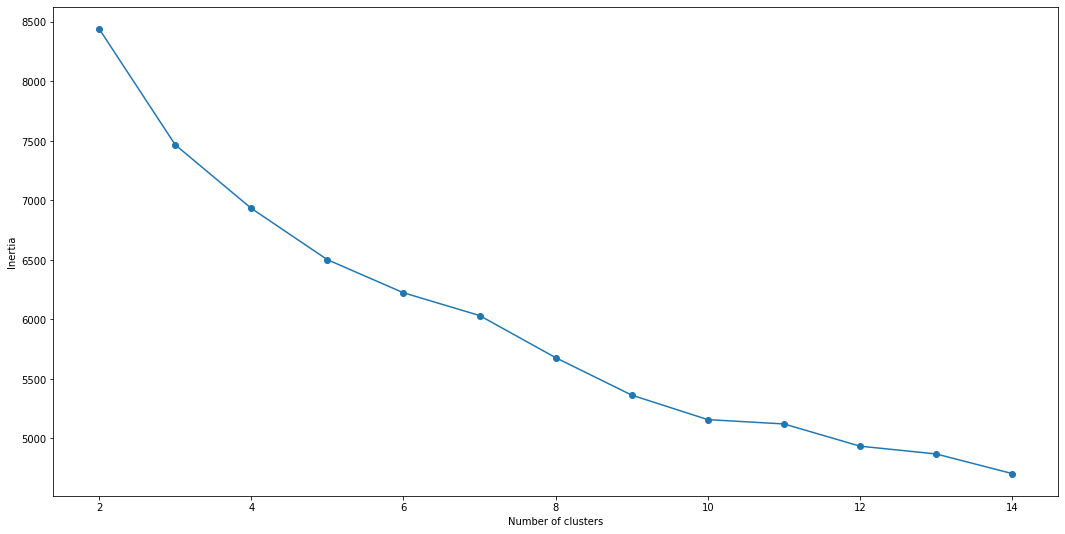

In [ ]:
plt.figure(figsize=(18,9))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

**(SILHOUETTE METHOD)**

Text(0, 0.5, 'Silhouette Score')

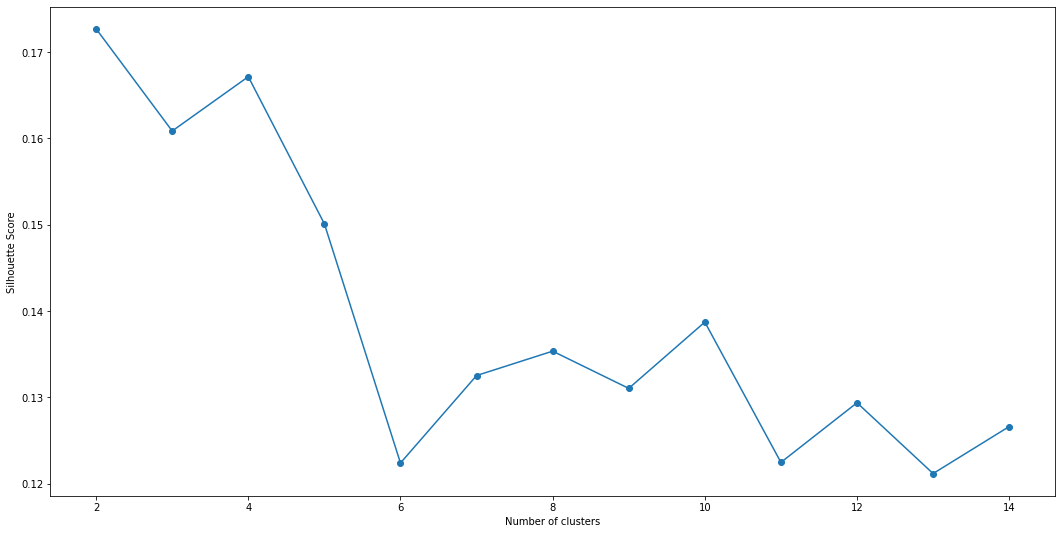

In [ ]:
plt.figure(figsize=(18,9))
plt.plot(frame['Cluster'], frame['Silhouette'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

In [ ]:
k=7 #is the selected number of clusters for now
#kmeansAlg = KMeans(k)
#kmeansAlg.fit(X)

kmeansAlg = kmeansLIST[k-2]

In [ ]:
def provideKlusteredX(kmeans,Xtok, Ytok):
  labels = kmeans.predict(Xtok)
  nk = kmeans.n_clusters
  labelslist = labels.tolist()
  print(len(labelslist))
  sum=0
  occurences=[0]*nk
  clustered_X=[]
  clustered_Y=[]

  for i in range(nk):
    clustered_X.append([])
    clustered_Y.append([])

  for i in range(len(labelslist)):
    clustered_X[labelslist[i]].append(Xtok[i])
    clustered_Y[labelslist[i]].append(Ytok[i])

  for i in range(nk):
    occurences[i]=labelslist.count(i)
    sum+=labelslist.count(i)

  plt.bar(range(nk),occurences)
  return clustered_X,clustered_Y

653


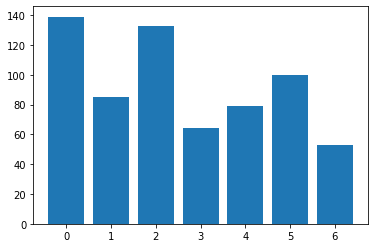

In [ ]:
clustered_totalX,clustered_totalY = provideKlusteredX(kmeansAlg, X, y)

216


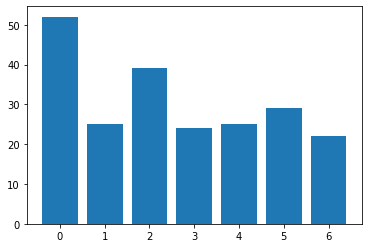

In [ ]:
clustered_testX,clustered_testY = provideKlusteredX(kmeansAlg, X_test, y_test)

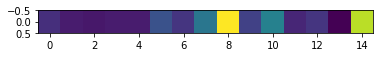

     0     1     2     3     4     5   ...    9     10    11    12   13    14
0 -0.01 -0.14 -0.16 -0.14 -0.14  0.24  ...  0.11  0.64 -0.07  0.03 -0.3  1.61

[1 rows x 15 columns]


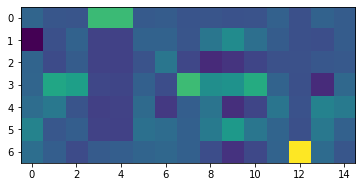

     0     1     2     3     4     5   ...    9     10    11    12    13    14
0  0.08 -0.20 -0.21  1.80  1.81 -0.11  ... -0.28 -0.25  0.01 -0.30  0.03 -0.09
1 -1.49 -0.30  0.03 -0.54 -0.55  0.04  ...  0.84  0.29 -0.08 -0.30 -0.34 -0.08
2  0.07 -0.38 -0.08 -0.54 -0.55 -0.26  ... -0.76 -0.49 -0.29 -0.29 -0.18 -0.15
3  0.10  1.37  1.25 -0.46 -0.48 -0.01  ...  0.97  1.49  0.04 -0.30 -0.89  0.14
4  0.23  0.45 -0.23 -0.57 -0.54  0.17  ... -0.83 -0.49  0.39 -0.28  0.65  0.48
5  0.67 -0.17 -0.05 -0.54 -0.55  0.30  ...  1.13  0.42  0.08 -0.30  0.44  0.02
6  0.26 -0.04 -0.38 -0.10 -0.04  0.07  ... -0.77 -0.44  0.06  3.35  0.20 -0.19

[7 rows x 15 columns]


In [ ]:
#SHOW COEFFICIENTS
plt.imshow(logreg.coef_, interpolation='nearest')
plt.show()
print(pd.DataFrame(logreg.coef_).round(2))

#SHOW CLUSTER CENTERS (NOT NECESSARILY REAL DATA)
plt.imshow(kmeansAlg.cluster_centers_, interpolation='nearest')
plt.show()
print(pd.DataFrame(kmeansAlg.cluster_centers_).round(2))

In [ ]:
def StatsOnKlustered(totalX,clusteredX, clusteredY):
  TOTALyes = 0
  for i in range(len(clusteredY)):
    TOTALyes += clusteredY[i].count(1.0)
  TOTALno = len(totalX)-TOTALyes
  presencerate = [] #instances of this type/total instances (in totalX)
  approvalrate = [] #approval rate for this type
  approvalcontributionrate = [] #approval for this type over the total n of approvals in totalX
  for i in range(len(clusteredY)):
    yes = clusteredY[i].count(1.0)
    no = clusteredY[i].count(0.0)
    instances = len(clusteredY[i])

    #print("Approved:",yes,"// Denied: ",no)
    presencerate.append(100*instances/len(totalX))
    approvalrate.append(100*yes/max(1,instances))
    approvalcontributionrate.append(100*yes/TOTALyes)
    
    print("Instance proportion:",presencerate[i],"// Approval rate:",approvalrate[i],"// Approval contribution:",approvalcontributionrate[i])
    print()
  return presencerate,approvalrate,approvalcontributionrate

In [ ]:
presencerateTOTAL,approvalrateTOTAL,approvalcontributionrateTOTAL = StatsOnKlustered(X,clustered_totalX,clustered_totalY)

Instance proportion: 21.28637059724349 // Approval rate: 28.776978417266186 // Approval contribution: 13.513513513513514

Instance proportion: 13.016845329249618 // Approval rate: 67.05882352941177 // Approval contribution: 19.256756756756758

Instance proportion: 20.367534456355283 // Approval rate: 11.278195488721805 // Approval contribution: 5.0675675675675675

Instance proportion: 9.800918836140887 // Approval rate: 92.1875 // Approval contribution: 19.93243243243243

Instance proportion: 12.09800918836141 // Approval rate: 48.10126582278481 // Approval contribution: 12.837837837837839

Instance proportion: 15.313935681470138 // Approval rate: 72.0 // Approval contribution: 24.324324324324323

Instance proportion: 8.116385911179172 // Approval rate: 28.30188679245283 // Approval contribution: 5.0675675675675675



In [ ]:
presencerateTEST,approvalrateTEST,approvalcontributionrateTEST = StatsOnKlustered(X_test,clustered_testX,clustered_testY)

Instance proportion: 24.074074074074073 // Approval rate: 26.923076923076923 // Approval contribution: 14.0

Instance proportion: 11.574074074074074 // Approval rate: 68.0 // Approval contribution: 17.0

Instance proportion: 18.055555555555557 // Approval rate: 12.820512820512821 // Approval contribution: 5.0

Instance proportion: 11.11111111111111 // Approval rate: 95.83333333333333 // Approval contribution: 23.0

Instance proportion: 11.574074074074074 // Approval rate: 52.0 // Approval contribution: 13.0

Instance proportion: 13.425925925925926 // Approval rate: 79.3103448275862 // Approval contribution: 23.0

Instance proportion: 10.185185185185185 // Approval rate: 22.727272727272727 // Approval contribution: 5.0



In [ ]:
def StatsOnKlusteredLogRegResults(logregAlg, totalX, clusteredX, clusteredY):
  y_pred = logregAlg.predict(totalX)
  TOTALyes = np.count_nonzero(y_pred == 1)
  TOTALno = np.count_nonzero(y_pred == 0)
  #COMPUTE ACCURACY OF THE MODEL FOR DIFFERENT CLUSTERS AND APPROVAL RATES
  presencerate = [] #instances of this type/total test instances
  approvalrate = [] #approval rate for this type
  approvalcontributionrate = [] #approval for this type over the total n of approvals in totalX
  accuracy = [] #logreg model accuracy per kluster
  for i in range(len(clusteredX)):
    if (len(clusteredX[i])>0):
      y_pred = logregAlg.predict(clusteredX[i])
      print("Accuracy of logistic regression classifier: ", logregAlg.score(clusteredX[i], clusteredY[i]))
      accuracy.append(100*logregAlg.score(clusteredX[i], clusteredY[i]))
    else:
      y_pred = []
      accuracy.append(0)

    yes = np.count_nonzero(y_pred == 1)
    no = np.count_nonzero(y_pred == 0)
    instances = len(clusteredY[i])

    presencerate.append(100*instances/len(totalX))
    approvalrate.append(100*yes/ max(1,instances))
    approvalcontributionrate.append(100*yes/TOTALyes)

    print("Instance proportion:",presencerate[i],"// Approval rate:",approvalrate[i],"// Approval contribution:",approvalcontributionrate[i])
    print()
  return presencerate,approvalrate,approvalcontributionrate, accuracy

In [ ]:
presencerateTESTpred,approvalrateTESTpred,approvalcontributionrateTESTpred, accuracyperK = StatsOnKlusteredLogRegResults(logreg,X_test,clustered_testX,clustered_testY)

Accuracy of logistic regression classifier:  0.8269230769230769
Instance proportion: 24.074074074074073 // Approval rate: 36.53846153846154 // Approval contribution: 16.666666666666668

Accuracy of logistic regression classifier:  1.0
Instance proportion: 11.574074074074074 // Approval rate: 68.0 // Approval contribution: 14.912280701754385

Accuracy of logistic regression classifier:  0.9230769230769231
Instance proportion: 18.055555555555557 // Approval rate: 10.256410256410257 // Approval contribution: 3.508771929824561

Accuracy of logistic regression classifier:  0.9583333333333334
Instance proportion: 11.11111111111111 // Approval rate: 100.0 // Approval contribution: 21.05263157894737

Accuracy of logistic regression classifier:  0.68
Instance proportion: 11.574074074074074 // Approval rate: 84.0 // Approval contribution: 18.42105263157895

Accuracy of logistic regression classifier:  1.0
Instance proportion: 13.425925925925926 // Approval rate: 79.3103448275862 // Approval cont

# ACTUAL TEST Y

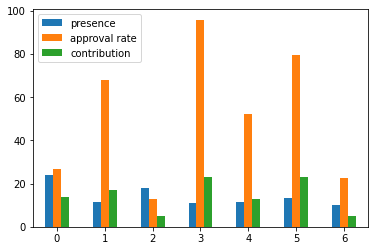

In [ ]:
df = pd.DataFrame({'presence': presencerateTEST,
                   'approval rate': approvalrateTEST,
                   'contribution': approvalcontributionrateTEST}, index=range(k))
ax = df.plot.bar(rot=0)

# PREDICTED TEST Y

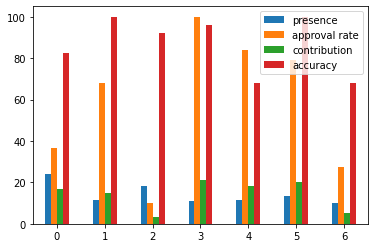

In [ ]:
df = pd.DataFrame({'presence': presencerateTESTpred,
                   'approval rate': approvalrateTESTpred,
                   'contribution': approvalcontributionrateTESTpred,
                   'accuracy': accuracyperK}, index=range(k))
ax = df.plot.bar(rot=0)

## **QUICK GENERAL OBSERVATIONS TO DEVELOP AND FURTHER SUPPORT:**

It seems that for different "profiles" of clients the model that has been learned about the whole dataset performs less reliably than for others (red bars in last plot, some 100% accuracy and some 68%, when the overall is supposed to be 87%).

This could become a problem if said model was left in charge of screening applicants' submissions as it would judge more fairly and consistently some clusters of customers than other, where it could behave more arbitrarily.

This, then, doesn't tell us about bias being present in the database directly, but in the model we trained.

Still, about bias in the dataset, this could be said:
Although it is clear than some clusters are more "approved" than others, this is absolutely to be expected. The problem, then, would reside in wheter the reasons behind these differences weren't just financial in nature. For this we should look at the weights developed by the model to ascertain what features are being given more rellevance. Currently "Income" is given the most importance, which seems reasonable. Further analysis is needed, and even so possible errors in that regard could still point again to a bad model (poor encoding choice, inexistent feature-selection process...) and not necessarily to biased source data (prejudice-based decision-making by the real bank).